<a href="https://colab.research.google.com/github/OPRiya/Human-Portrait-Project/blob/main/New_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/MarcoForte/FBA_Matting.git
!mv FBA_Matting/* .

Cloning into 'FBA_Matting'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 144 (delta 11), reused 22 (delta 11), pack-reused 119
Receiving objects: 100% (144/144), 4.60 MiB | 41.65 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [ ]:
from demo import np_to_torch, pred, scale_input
from dataloader import read_image, read_trimap
from networks.models import build_model
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
ip_path = '/content/Image1 (1).jpg'

In [ ]:
# ModNet model for finding the semantic segmentation map

In [ ]:
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

/content
Cloning into 'MODNet'...
remote: Enumerating objects: 273, done.
remote: Total 273 (delta 0), reused 0 (delta 0), pack-reused 273
Receiving objects: 100% (273/273), 60.77 MiB | 41.18 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/MODNet
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
100% 26.3M/26.3M [00:00<00:00, 230MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import os
from google.colab import files

# clean and rebuild the image folders
input_folder = 'demo/image_matting/colab/input'
if os.path.exists(input_folder):
  shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = 'demo/image_matting/colab/output'
Trimap_folder = 'demo/image_matting/colab/Trimap_output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

if os.path.exists(Trimap_folder):
  shutil.rmtree(Trimap_folder)
os.makedirs(Trimap_folder)

# upload images (PNG or JPG)
image_names = list(files.upload().keys())
for image_name in image_names:
  shutil.move(image_name, os.path.join(input_folder, image_name))


Saving Image1.jpg to Image1.jpg
Saving Image2.jpg to Image2.jpg
Saving Image3.jpg to Image3.jpg
Saving image6.jpg to image6.jpg
Saving image7.jpg to image7.jpg
Saving image8.jpg to image8.jpg


In [ ]:

!python -m demo.image_matting.colab.inference \
        --input-path demo/image_matting/colab/input \
        --output-path demo/image_matting/colab/output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt


Process image: Image2.jpg
Process image: Image1.jpg
Process image: image7.jpg
Process image: image8.jpg
Process image: image6.jpg
Process image: Image3.jpg


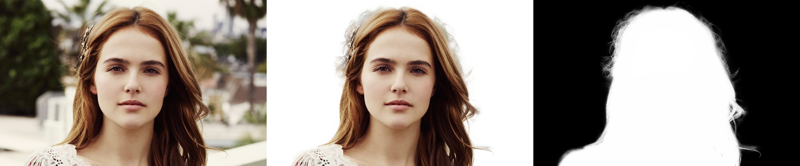

Image2.jpg 



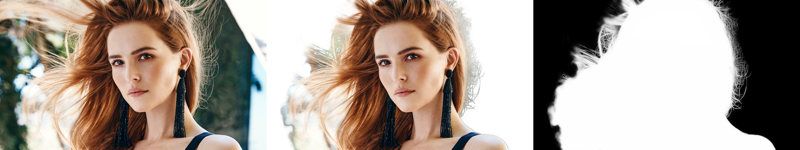

Image1.jpg 



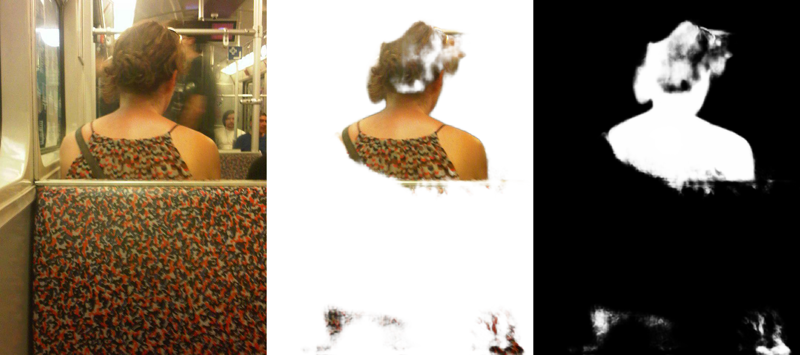

image7.jpg 



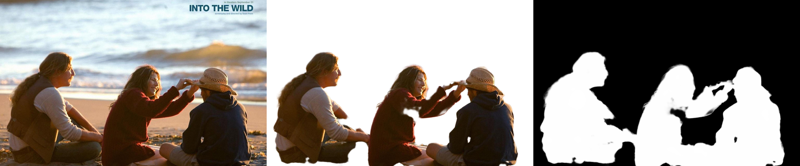

image8.jpg 



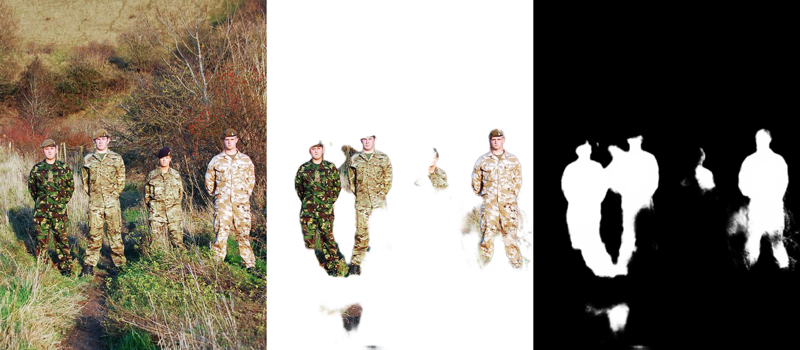

image6.jpg 



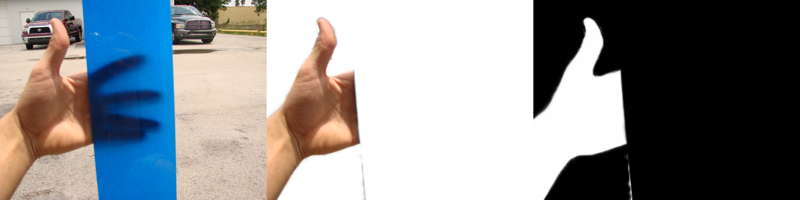

Image3.jpg 



In [ ]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

# visualize all images
image_names = os.listdir(input_folder)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(input_folder, image_name))
  matte = Image.open(os.path.join(output_folder, matte_name))
  display(combined_display(image, matte))
  print(image_name, '\n')


In [ ]:
%matplotlib inline
import cv2, os, sys
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from numpy import asarray
import PIL 


In [ ]:
os.getcwd()

'/content/MODNet'

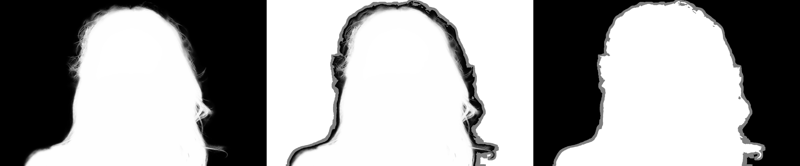

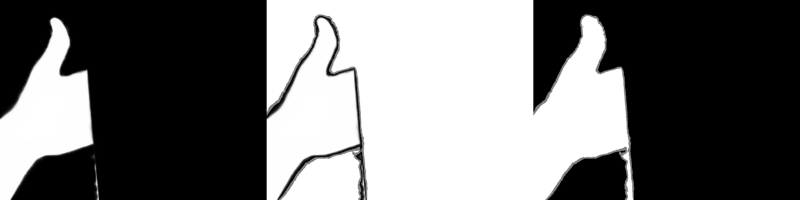

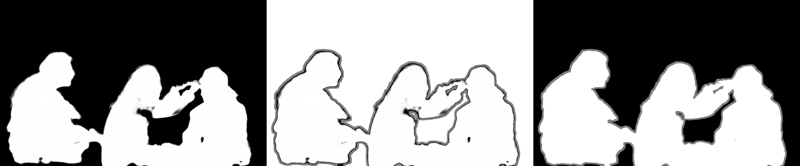

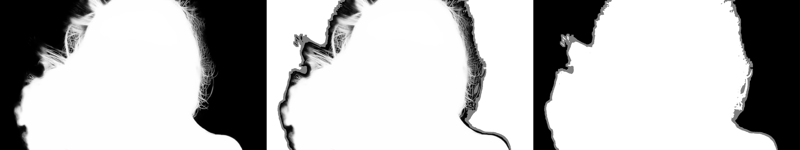

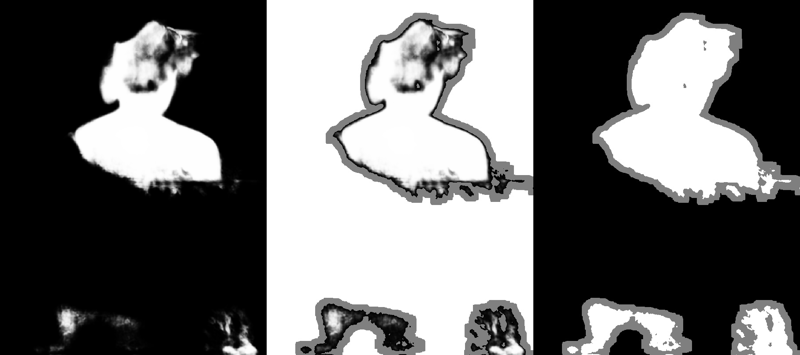

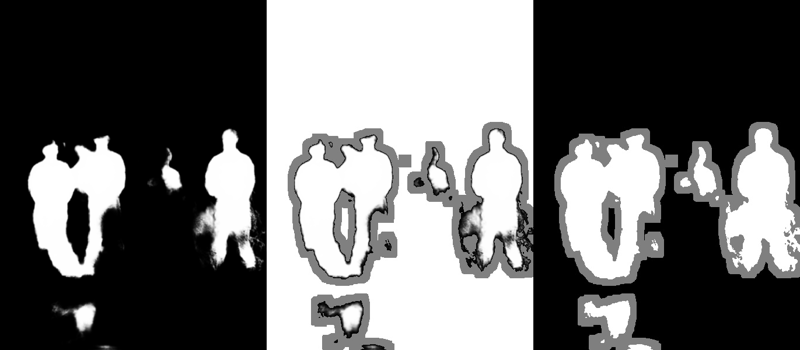

In [ ]:
def trimap(probs, size, conf_threshold):

  mask = (probs > 0.05).astype(np.uint8) * 255
  pixels = 2 * size + 1
  kernel = np.ones((pixels, pixels), np.uint8)
  dilation = cv2.dilate(mask, kernel, iterations=1)
  remake = np.zeros_like(mask)
  remake[dilation == 255] = 127  # Set every pixel within dilated region as probably foreground.
  remake[probs > conf_threshold] = 255  # Set every pixel with large enough probability as definitely foreground.
  return remake

size = 10;         # Unknown Region Thickness

#height, width = image.shape[:2]
image_names = os.listdir(output_folder)
for img_path in image_names:
  img= Image.open(os.path.join(output_folder,img_path))
  #plt.imshow(img)
  trimap_name = img_path.split('.')[0] + '.jpg'
  #shutil.move(trimap_name, os.path.join(Trimap_folder, trimap_name))
  x=trimap(np.array(img), size, 2)
  #plt.imshow(x)
  #x= Image.fromarray(x)
  cv2.imwrite(os.path.join(Trimap_folder, trimap_name), x) 
  x= Image.open(os.path.join(Trimap_folder, trimap_name))
  image = Image.open(os.path.join(input_folder, image_name))
  matte = Image.open(os.path.join(output_folder, matte_name))
  #display(combined_display(image, matte))
  display(combined_display(img, x))
  #print("hii")
  #plt.imshow(x)
  #plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# using FBA model on this generated trimap

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!gdown  https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1

model = build_model('FBA.pth')
model.cuda()

In [ ]:
fg, bg, alpha = pred(image, trimap, model)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


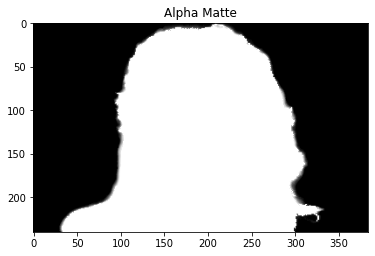

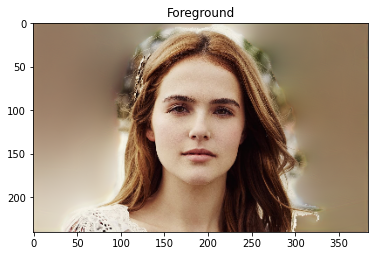

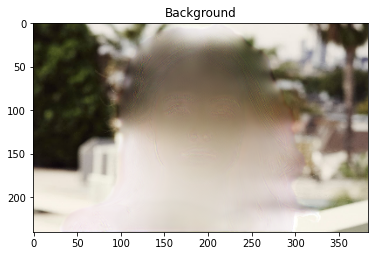

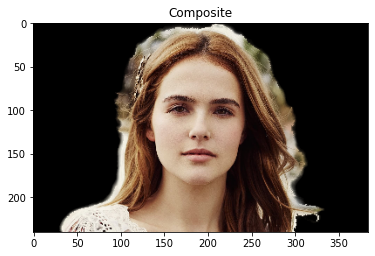

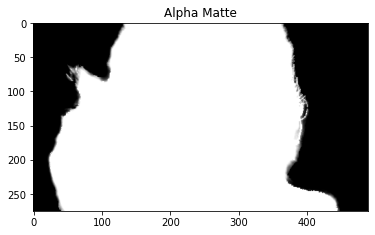

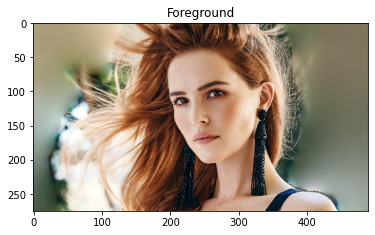

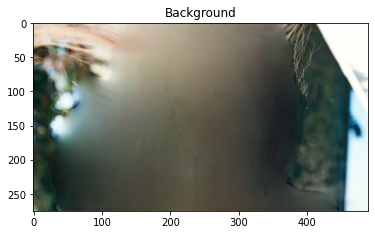

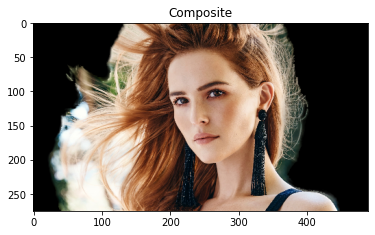

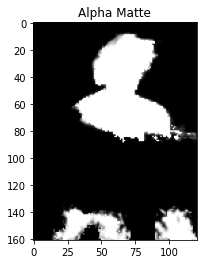

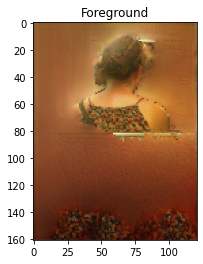

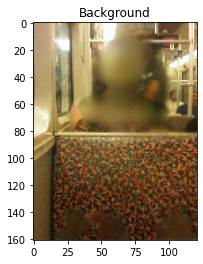

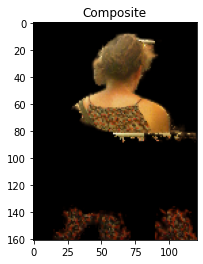

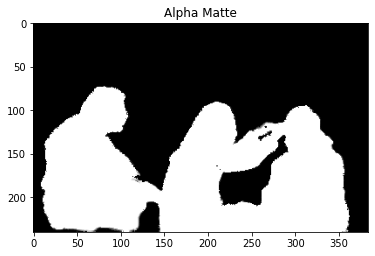

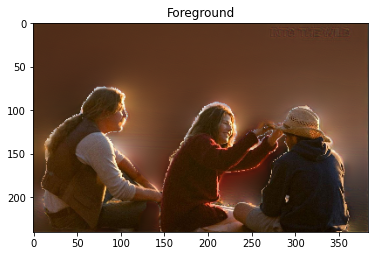

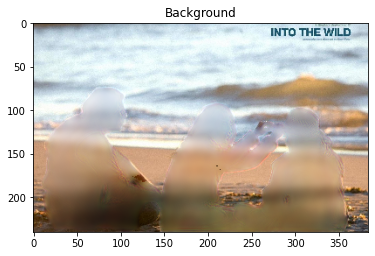

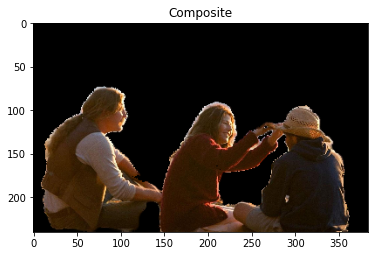

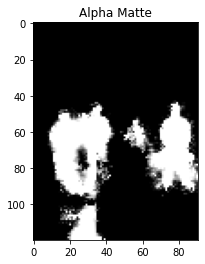

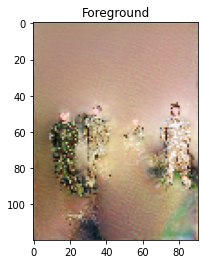

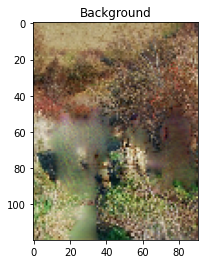

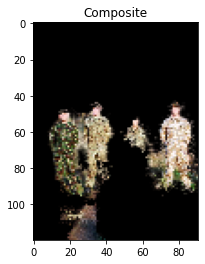

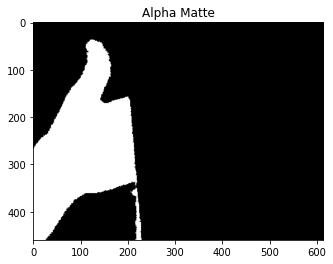

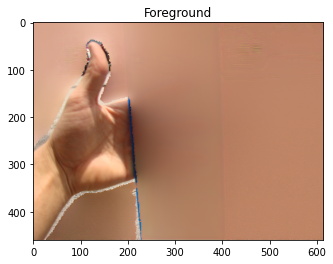

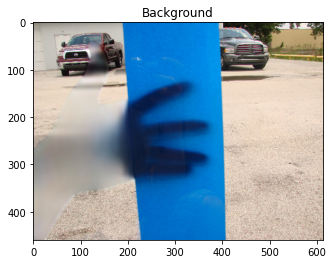

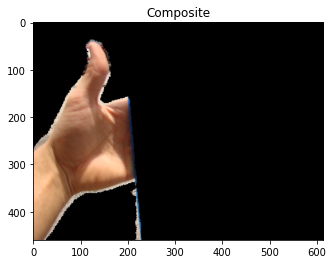

In [ ]:
image_names= os.listdir(input_folder)
trimap_names=os.listdir(Trimap_folder)
for img_path in image_names:
  '''
  img= Image.open(os.path.join(input_folder, img_path))
  img=np.array(img)
  trimap=Image.open(os.path.join(Trimap_folder, trimap_path))
  trimap=np.array(img)
  fg, bg, alpha = pred(img, trimap, model)
  '''
  image_path = os.path.join(input_folder, img_path)
  trimap_path= os.path.join(Trimap_folder, img_path)
  #print(image_path, trimap_path)
  image = read_image(image_path)   
  image = cv2.resize(image, (len(image[0])//5, len(image)//5))
  #print(img_path, image.shape)
  trimap = read_trimap(trimap_path)
  trimap = cv2.resize(trimap, (len(trimap[0])//5, len(trimap)//5))
  #print(trimap_path, trimap.shape)
  fg, bg, alpha = pred(image, trimap, model)
  plt.title('Alpha Matte')
  plt.imshow(alpha, cmap='gray', vmin=0, vmax=1)
  plt.show()
  plt.title('Foreground')
  plt.imshow(fg)
  plt.show()
  plt.title('Background')
  plt.imshow(bg)
  plt.show()
  plt.title('Composite')
  plt.imshow(fg*alpha[:,:,None])
  plt.show()

In [ ]:
image_path = os.path.join(input_folder, img_path)
trimap_path= os.path.join(Trimap_folder, trimap_path)
image = read_image(image_path)
image = cv2.resize(image, (len(image[0])//5, len(image)//5))
trimap = read_trimap(trimap_path)

In [ ]:
image.shape

(275, 489, 3)

In [ ]:
trimap.shape

(807, 605, 2)

In [ ]:
image.reshape(100,100)

ValueError: ignored